In [11]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from datasets import load_dataset, Dataset as HFDataset
from sklearn.metrics import accuracy_score
import warnings
import string
import os
import shutil
import torch
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sentencepiece
import evaluate
from sacrebleu import BLEU
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, pipeline, EvalPrediction, TrainerCallback
import sys
import tensorflow as tf

# **Data Preprocessing**

### **Load The Data**

In [12]:
dataset = load_dataset("zeydferhat/arabic_functional_text_dimensions")
print(dataset.keys())

dict_keys(['train', 'test'])


In [13]:
print(dataset['train'].column_names)
print(dataset['train'][0])

['index', 'Text', 'label']
{'index': 2835, 'Text': 'وحين أنامته الممرضة من جديد خطوت عائدًا إلى غرفة زوجتي.. ولكن ما إن سمعت صوت خطواتي حتى عدت إلى عالمي، عالم بعيد مطوق بشيء اسمه حب حقيقي.. حب لا إلزام فيه ولا جزاء.. حب لذاته، بلا تعويض، بلا ثمن، بلا خوف، حب صافٍ لم أحس به أبدًا من قبل، أبدًا أبدًا، حب لذلك الطفل الذي ولد مني، بسببي، ومن أجلي، وكان ثمنه حبي لها، وحبها لي، ليس غير.. حب لا غاية له، ولا هدف، حب مترع العطاء، يطوف في صدري حتى أحسه يسكب في جسدي، كما لو أنه ينضح ندى فيبعث فيَّ فرحة اللقاء الحقيقي الذي لم يلوث بعد بتعقيدات الحياة، بقانون خذ وهات، وقانون أنت وأنا، وقانون أين ولماذا وكيف.. مجرد عطاء محض غير مشوب بأي سؤال، أو طلب، أو انتظار، أو تلكؤ، أو تردد.. مثل ماذا؟ مثل لا شيء، مثل ذاته ليس غير.. لو قدر لنبعة الماء أن تحس، إذن لأحسَّت ذلك الشعور، العطاء المحض الذي يخلق من جديد كلما شرب عابر من مائها ..', 'label': 'Personal '}


In [14]:
df = dataset['train'].to_pandas()
df.shape

(2380, 3)

### **Clean and Normalize Words**

In [ ]:
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    text = re.sub(" و ", " ", text)
    return text


# Define Arabic diacritics
arabic_diacritics = re.compile(r"""
    ّ    | # Shadda
    َ    | # Fatha
    ً    | # Tanwin Fath
    ُ    | # Damma
    ٌ    | # Tanwin Damm
    ِ    | # Kasra
    ٍ    | # Tanwin Kasr
    ْ    | # Sukun
    ـ      # Tatweel
""", re.VERBOSE)

def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text

def remove_non_arabic_and_numbers(text):
    # Keep only Arabic characters and spaces
    arabic_pattern = re.compile(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF\s]')
    return arabic_pattern.sub('', text)

# Define punctuation characters
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations = arabic_punctuations + english_punctuations

def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations)
    return text.translate(translator)


def normalize_arabic_text(text):
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    text = remove_non_arabic_and_numbers(text)
    text = remove_punctuations(text)
    return text


In [16]:
# Extract all text from the 'Text' column
text = ' '.join(df["Text"])
text = normalize_arabic_text(text)
words = text.split()
vocab = list(set(words))
print(len(vocab))

72804


### **Generate Synthetic Training Data**

#### **Insertion**

In [17]:
def insert(word, max_typos=2):
    arabic_letters = 'ابتثجحخدذرزسشصضطظعغفقكلمنهوي'
    possible_words = set()
    for _ in range(max_typos):
        pos = random.randint(0, len(word))
        letter = random.choice(arabic_letters)
        new_word = word[:pos] + letter + word[pos:]
        possible_words.add(new_word)
    return possible_words


#### **Deletion**

In [18]:
def delete(word):
    if len(word) < 2:
        return set()
    pos = random.randint(0, len(word)-1)
    return {word[:pos] + word[pos+1:]}

#### **Replacing**

In [19]:
def replace(word):
    arabic_letters = 'ابتثجحخدذرزسشصضطظعغفقكلمنهوي'
    if len(word) < 1:
        return set()
    pos = random.randint(0, len(word)-1)
    letter = random.choice(arabic_letters)
    return {word[:pos] + letter + word[pos+1:]}

#### **Switching**

In [20]:
def switch(word):
    if len(word) < 2:
        return set()
    pos = random.randint(0, len(word)-2)
    new_word = word[:pos] + word[pos+1] + word[pos] + word[pos+2:]
    return {new_word}

In [ ]:
def add_arabic_typo(word, max_total_typos=3):
    if len(word) < 2:
        return [word]

    common_typos = {
        'ا': ['أ', 'إ', 'آ', ''],
        'أ': ['ا', 'إ', 'ء'],
        'ة': ['ه', 'ت'],
        'ه': ['ة', 'ح'],
        'ي': ['ى', 'ئ'],
        'و': ['ؤ', 'ء', ''],
        'ن': ['ت', 'ب'],
        'ت': ['ث', 'ن'],
        'س': ['ش', 'ص'],
    }

    typo_ops = [insert, delete, replace, switch]
    typo_variants = set()

    
    for _ in range(2):
        pos = random.randint(0, len(word)-1)
        char = word[pos]
        if char in common_typos:
            replacement = random.choice(common_typos[char])
            typo = word[:pos] + replacement + word[pos+1:]
            typo_variants.add(typo)

    
    while len(typo_variants) < max_total_typos:
        op = random.choice(typo_ops)
        typo_variants.update(op(word))

    return list(typo_variants)

### **Create Training Pairs**

In [ ]:
synthetic_data = []

for word in vocab [:10000]:
    typo_variants = add_arabic_typo(word)
    for incorrect in typo_variants:
        if incorrect != word:
            synthetic_data.append({'inputs': incorrect.strip(), 'targets': word.strip()})

df = pd.DataFrame(synthetic_data)

df.to_csv("autocorrect_dataset.csv", index=False)


In [23]:
with open("autocorrect_dataset.csv", encoding="utf-8") as f:
    for i in range(10):
        print(f.readline())

inputs,targets

الاسررار,الاسرار

إلاسرار,الاسرار

الاسار,الاسرار

الاسرارك,الاسرار

بومركبه,ومركبه

مركبه,ومركبه

زومركبه,ومركبه

بأتوا,باتوا

باتوإ,باتوا



In [21]:
df.shape

(31851, 2)

### **Data Cleaning**

In [ ]:
def clean_dataset(df):

    df = df.dropna(subset=["inputs", "targets"])

    df = df[df["inputs"].apply(lambda x: isinstance(x, str))]
    df = df[df["targets"].apply(lambda x: isinstance(x, str))]

    df = df.reset_index(drop=True)

    return df


### **Data Spliting**

In [28]:
# Load and clean dataset
df = pd.read_csv("autocorrect_dataset.csv")
df = clean_dataset(df)

# Train/validation split
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
train_dataset = HFDataset.from_pandas(train_df)
val_dataset = HFDataset.from_pandas(val_df)

In [27]:
df.shape

(31851, 2)

### **Check Duplicated Values**



In [28]:
duplicates = train_df[train_df['inputs'] == train_df['targets']]
print(f"Found {len(duplicates)} identical input-output pairs")

Found 0 identical input-output pairs


# **Model Fine-Tuning**

### **Load Tokenizer & Model**




In [ ]:
tokenizer = AutoTokenizer.from_pretrained("CAMeL-Lab/arat5-coda", legacy=False)
model = AutoModelForSeq2SeqLM.from_pretrained("CAMeL-Lab/arat5-coda")

def tokenize(batch):
    input_encodings = tokenizer(batch['inputs'], padding="max_length", truncation=True, max_length=128)
    target_encodings = tokenizer(batch['targets'], padding="max_length", truncation=True, max_length=128)

    labels = target_encodings["input_ids"]
    labels = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label]
        for label in labels
    ]
    
    return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": labels
    }


In [30]:
# Apply tokenization
train_dataset = train_dataset.map(tokenize, batched=True, remove_columns=["inputs", "targets"])
val_dataset = val_dataset.map(tokenize, batched=True, remove_columns=["inputs", "targets"])

Map: 100%|██████████| 3186/3186 [00:01<00:00, 1660.88 examples/s]


### **Model Training Setup**

In [31]:
class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        self.eval_losses = []
        self.train_losses = []

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if "eval_loss" in metrics:
            self.eval_losses.append((state.global_step, metrics["eval_loss"]))

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.train_losses.append((state.global_step, logs["loss"]))


In [ ]:
training_args = Seq2SeqTrainingArguments(

      output_dir="./results",
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      warmup_steps=200,
      warmup_ratio=0.1,
      weight_decay=0.01,
      gradient_accumulation_steps=1,
      learning_rate=2e-5,
      fp16=True,
      logging_dir="./logs",
      logging_steps=500,
      predict_with_generate=True,
      generation_max_length=16,
      gradient_checkpointing=True,
      max_grad_norm=1.0,
      lr_scheduler_type="cosine",
      optim="adafactor",
      report_to="tensorboard"
      )

loss_tracker = LossTrackerCallback()

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[loss_tracker]
)



# **Model Training**

### **Train The Model**

In [34]:
num_epochs = 2

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    trainer.train()
    eval_results = trainer.evaluate()
    print(f"Validation Loss: {eval_results['eval_loss']:.4f}")


Epoch 1/2


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
500,3.896200
1000,2.641700
1500,2.358500
2000,2.220500
2500,2.088500
3000,2.054900
3500,2.009200
4000,1.913900
4500,1.923300
5000,1.894700


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Metric computation error: name 'bleu_scorer' is not defined
Validation Loss: 1.5322

Epoch 2/2


Step,Training Loss
500,1.913600
1000,1.863400
1500,1.792000
2000,1.737900
2500,1.659600
3000,1.646200
3500,1.649300
4000,1.556200
4500,1.583800
5000,1.555700


Metric computation error: name 'bleu_scorer' is not defined
Validation Loss: 1.3276


# **Evaluation**

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import evaluate

label_names = list(set(dataset["train"]["label"]))
label2id = {label: i for i, label in enumerate(label_names)}
id2label = {i: label for label, i in label2id.items()}

# Load tokenizer and model
model_path = "D:\\NLP_model\\my_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load metric
metric = evaluate.load("accuracy")

# Evaluation loop
total_samples = 100
predictions = []
references = []

for example in dataset["test"].select(range(total_samples)):
    text = example["Text"]
    true_label = label2id[example["label"]]  # convert to integer
    
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        pred_id = torch.argmax(outputs.logits, dim=1).item()
    
    predictions.append(pred_id)
    references.append(true_label)

# Compute accuracy
results = metric.compute(predictions=predictions, references=references)
print(f"\n Accuracy on {total_samples} test samples: {results['accuracy']:.2f}")



Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at D:\NLP_model\my_model and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Accuracy on 100 test samples: 0.05


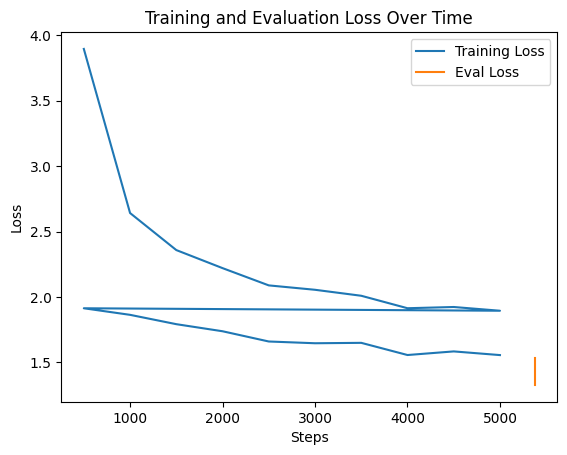

In [42]:
# Plot training loss
steps, train_losses = zip(*loss_tracker.train_losses)
plt.plot(steps, train_losses, label="Training Loss")

# Plot evaluation loss
if loss_tracker.eval_losses:
    eval_steps, eval_losses = zip(*loss_tracker.eval_losses)
    plt.plot(eval_steps, eval_losses, label="Eval Loss")

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Evaluation Loss Over Time")
plt.show()

# **GUI**

In [2]:
import tkinter as tk
from tkinter import ttk
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch


# Function to perform correction    
def correct_text():
    input_text = input_box.get("1.0", tk.END).strip()
    if not input_text:
        output_label.config(text="يرجى إدخال نص")
        return

    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=128)
    corrected = tokenizer.decode(outputs[0], skip_special_tokens=True)
    output_label.config(text=corrected)

# Create GUI window
root = tk.Tk()
root.title("مصحح اللغة العربية")
root.geometry("600x400")
root.configure(bg="#1e1e2f")

# Title
title = tk.Label(root, text="تصحيح النصوص العربية", font=("Segoe UI", 20), bg="#1e1e2f", fg="#ffffff")
title.pack(pady=10)

# Input Text Box
input_box = tk.Text(root, font=("Segoe UI", 14), height=6, wrap=tk.WORD, bg="#2c2c3c", fg="#ffffff", insertbackground="white", padx=10, pady=10)
input_box.pack(padx=20, pady=10, fill=tk.BOTH)

# Correct Button
correct_button = ttk.Button(root, text="تصحيح", command=correct_text)
style = ttk.Style()
style.theme_use("clam")
style.configure("TButton", font=("Segoe UI", 12), foreground="white", background="#3a86ff", padding=10)
style.map("TButton", background=[("active", "#265df2")])
correct_button.pack(pady=10)

# Output Label
output_label = tk.Label(root, text="", font=("Segoe UI", 14), wraplength=560, justify="right", bg="#1e1e2f", fg="#00ffb3")
output_label.pack(padx=20, pady=10)

root.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\Dell\AppData\Local\Temp\ipykernel_19824\936617715.py", line 14, in correct_text
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
NameError: name 'tokenizer' is not defined. Did you mean: 'AutoTokenizer'?
Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\Dell\AppData\Local\Temp\ipykernel_19824\936617715.py", line 14, in correct_text
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)
NameError: name 'tokenizer' is not defined. Did you mean: 'AutoTokenizer'?
